<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>

In [219]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            if ord(c)-ord('A') >= 0 and ord(c)-ord('A') < dimensions:
                new_data = []
                for i in range(0, dimensions):
                    new_data.append([0])
                    
                new_data[ord(c)-ord('A')] = [1]
                data.append(new_data)
                if max_len != None:
                    if len(data) >= max_len:
                        print("all loaded")    
                        return data
                    
    print("all loaded")    
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

#def cross_entropy(target, x):
#    data = np.clip(x, 1, 

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]        # Takes in the output of the previous layer. h[-1] is the hidden state of the last timestep of the layer
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].y
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps, t):
        gradient, loss = self.layers[-1].der_MSE(target)
        #print("MSE gradient: " + str(gradient))
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps, t)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps, t)
        return loss
    
    def predict(self, input_data):
        self.clear_memory()
        next_letter = []
        out_letter = []
        for i in range(0, len(input_data)):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(200, 500):
            maximum = 0;
            max_index = 0;
            for k in range(0, self.layers[0].input_size):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k
            out_letter = np.empty(next_letter.shape)
            out_letter.fill(0)
            out_letter[max_index,0] = 1
            print_output += chr(ord('A')+max_index)
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # M
        self.output_size = output_size # N
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        self.y       = np.empty((output_size, 1))
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.mWz = np.zeros((output_size, input_size))
        self.vWz = np.zeros((output_size, input_size))
        self.mWr = np.zeros((output_size, input_size))
        self.vWr = np.zeros((output_size, input_size))
        self.mWh = np.zeros((output_size, input_size))
        self.vWh = np.zeros((output_size, input_size))
        
        self.mUz = np.zeros((output_size, output_size))
        self.vUz = np.zeros((output_size, output_size))
        self.mUr = np.zeros((output_size, output_size))
        self.vUr = np.zeros((output_size, output_size))
        self.mUh = np.zeros((output_size, output_size))
        self.vUh = np.zeros((output_size, output_size))
        
        self.mbz = np.zeros((output_size, 1))
        self.vbz = np.zeros((output_size, 1))
        self.mbr = np.zeros((output_size, 1))
        self.vbr = np.zeros((output_size, 1))
        self.mbh = np.zeros((output_size, 1))
        self.vbh = np.zeros((output_size, 1))
        
        self.epsilon = 0.000000001
        
        #self.errors  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
    def weights_init(self, rows, cols, bias=False):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(0,0,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data):
        
        self.inputs = np.append(self.inputs, [input_data])
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.zeros((self.output_size, 1))
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz      #Nx1
        new_z = activation_function(new_z, "sigmoid")
        #print("=======")
        #print("io : ", self.input_size, self.output_size)
        #print("shapes: ", self.Wz.shape,' @ ',len(input_data),'+',self.Uz.shape,' @ ',prev_h.shape,'+',self.bz.shape)
        #print("new_z: ",new_z.shape)
        #print("z: ", self.z)
        #print("=======")
        #print("new_z: ", new_z)
        #print("=======")
        #print("z and new z -> ",self.z.shape, new_z.shape)
        #print("=======")
        self.z = np.append(self.z, [new_z], axis=0)
        #if(self.z.shape[0]>=1):
        #    
        #    self.z = np.vstack((self.z,new_z[None]))
        #else:
        #    new_z = new_z.reshape((1,new_z.shape[0], new_z.shape[1]))
        #    self.z = new_z
        ##print("Finally : ", self.z)
        
        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = activation_function(new_r, "sigmoid")
        self.r = np.append(self.r, [new_r], axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.Uh @ (new_r * prev_h) + self.bh
        new_h_tilde = activation_function(new_h_tilde, "tanh")
        self.h_tilde = np.append(self.h_tilde, [new_h_tilde], axis=0)
        
        new_h = new_z * prev_h + (1 - new_z) * new_h_tilde
        self.h = np.append(self.h, [new_h], axis=0)
        if self.last_activation != None:
            self.y = activation_function(new_h, self.last_activation)
        else:
            self.y = new_h
        
        
        #if len(self.z) > 30:
        #    self.z = np.delete(self.z, 0, 0)
        #if len(self.r) > 30:
        #    self.r = np.delete(self.r, 0, 0)
        #if len(self.h_tilde) > 30:
        #    self.h_tilde = np.delete(self.h_tilde, 0, 0)
        #if len(self.h) > 30:
        #    self.h = np.delete(self.h, 0, 0)
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        self.inputs  = np.empty((0,self.input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.mWz = np.zeros((self.output_size, self.input_size))
        self.vWz = np.zeros((self.output_size, self.input_size))
        self.mWr = np.zeros((self.output_size, self.input_size))
        self.vWr = np.zeros((self.output_size, self.input_size))
        self.mWh = np.zeros((self.output_size, self.input_size))
        self.vWh = np.zeros((self.output_size, self.input_size))
        
        self.mUz = np.zeros((self.output_size, self.output_size))
        self.vUz = np.zeros((self.output_size, self.output_size))
        self.mUr = np.zeros((self.output_size, self.output_size))
        self.vUr = np.zeros((self.output_size, self.output_size))
        self.mUh = np.zeros((self.output_size, self.output_size))
        self.vUh = np.zeros((self.output_size, self.output_size))
        
        self.mbz = np.zeros((self.output_size, 1))
        self.vbz = np.zeros((self.output_size, 1))
        self.mbr = np.zeros((self.output_size, 1))
        self.vbr = np.zeros((self.output_size, 1))
        self.mbh = np.zeros((self.output_size, 1))
        self.vbh = np.zeros((self.output_size, 1))
        #self.errors  = np.empty((0,self.input_size,1))  # TxMx1, inputs(t) = Mx1
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(self.y-target) * softmax(self.y), np.power(target - self.y, 2)
        return 2*(self.y-target), np.power(target - self.y, 2)

     

<img src="images\article_derivative_image.png" width=800>

In [220]:
class Layer(Layer):    
    
    def descent(self, gradient, input_data, learning_rate, max_steps, t):
        
        first_index = 0 if len(self.h) <= max_steps else len(self.h) - max_steps
        step = 1
        
        d0 = gradient
        d1=0
        d2=0
        d3=0
        d4=0
        d5=0
        d6=0
        d7=0
        d8=0
        d9=0
        d10=0
        d11=0
        d12=0
        d13=0
        d14=0
        d15=0
        d16=0
        d17=0
        d18=0
        d19=0
        d20=0
        dx=0
        dh=0
        dWz=0
        dWr=0
        dWh=0
        dUz=0
        dUr=0
        dUh=0
        dbz=0
        dbr=0
        dbh=0
        
        
        while len(self.h) - step > first_index:
            x = np.array(input_data[len(self.h) - step])
            prev_h = self.h[len(self.h) - step-1] if len(self.h) - step-1 >= 0 else np.zeros((self.output_size, 1))
            h_tilde = self.h_tilde[len(self.h) - step]
            h = self.h[len(self.h) - step]
            z = self.z[len(self.h) - step]
            r = self.r[len(self.h) - step]
            
            d1 = d0 * z
            d2 = d0 * prev_h
            d3 = d0 * h_tilde
            d4 = -d3
            d5 = d2 + d4
            d6 = d0 * (1-z)
            d7 = d5 * (z * (1-z))
            d8 = d6 * (1 - np.power(h_tilde, 2))
            
            d9 = self.Wh.T @ d8 
            d10= self.Uh.T @ d8 
            d11= self.Wz.T @ d7
            d12= self.Uz.T @ d7
            d14= d10 * r
            d15= d10 * prev_h
            d16= d15 * (r * (1-r))
            d17= self.Ur.T @ d16
            d13= self.Wr.T @ d16
            
            if step == 1:
                dx = d13 + d11 + d9
            dh = d1 + d14 + d17 + d12
            dWr+= d16 @ x.T
            dWh+= d8 @ x.T
            dWz+= d7 @ x.T
            dUr+= d16 @ prev_h.T
            dUh+= d8 @ (r * prev_h).T
            dUz+= d7 @ prev_h.T
            
            dbh+= d8
            dbr+= d16
            dbz+= d7
            
            d0 = dh
            
            step += 1
        
        self.mWz = self.beta1 * self.mWz + (1 - self.beta1) * dWz
        self.vWz = self.beta2 * self.vWz + (1 - self.beta2) * np.power(dWz, 2)
        self.mWr = self.beta1 * self.mWr + (1 - self.beta1) * dWr
        self.vWr = self.beta2 * self.vWr + (1 - self.beta2) * np.power(dWr, 2)
        self.mWh = self.beta1 * self.mWh + (1 - self.beta1) * dWh
        self.vWh = self.beta2 * self.vWh + (1 - self.beta2) * np.power(dWh, 2)
        
        self.mUz = self.beta1 * self.mUz + (1 - self.beta1) * dUz
        self.vUz = self.beta2 * self.vUz + (1 - self.beta2) * np.power(dUz, 2)
        self.mUr = self.beta1 * self.mUr + (1 - self.beta1) * dUr
        self.vUr = self.beta2 * self.vUr + (1 - self.beta2) * np.power(dUr, 2)
        self.mUh = self.beta1 * self.mUh + (1 - self.beta1) * dUh
        self.vUh = self.beta2 * self.vUh + (1 - self.beta2) * np.power(dUh, 2)
        
        self.mbz = self.beta1 * self.mbz + (1 - self.beta1) * dbz
        self.vbz = self.beta2 * self.vbz + (1 - self.beta2) * np.power(dbz, 2)
        self.mbr = self.beta1 * self.mbr + (1 - self.beta1) * dbr
        self.vbr = self.beta2 * self.vbr + (1 - self.beta2) * np.power(dbr, 2)
        self.mbh = self.beta1 * self.mbh + (1 - self.beta1) * dbh
        self.vbh = self.beta2 * self.vbh + (1 - self.beta2) * np.power(dbh, 2)
        
        mWz_hat = self.mWz / (1 - np.power(self.beta1, t))
        vWz_hat = self.vWz / (1 - np.power(self.beta2, t))
        mWr_hat = self.mWr / (1 - np.power(self.beta1, t))
        vWr_hat = self.vWr / (1 - np.power(self.beta2, t))
        mWh_hat = self.mWh / (1 - np.power(self.beta1, t))
        vWh_hat = self.vWh / (1 - np.power(self.beta2, t))
        mUz_hat = self.mUz / (1 - np.power(self.beta1, t))
        vUz_hat = self.vUz / (1 - np.power(self.beta2, t))
        mUr_hat = self.mUr / (1 - np.power(self.beta1, t))
        vUr_hat = self.vUr / (1 - np.power(self.beta2, t))
        mUh_hat = self.mUh / (1 - np.power(self.beta1, t))
        vUh_hat = self.vUh / (1 - np.power(self.beta2, t))
        mbz_hat = self.mbz / (1 - np.power(self.beta1, t))
        vbz_hat = self.vbz / (1 - np.power(self.beta2, t))
        mbr_hat = self.mbr / (1 - np.power(self.beta1, t))
        vbr_hat = self.vbr / (1 - np.power(self.beta2, t))
        mbh_hat = self.mbh / (1 - np.power(self.beta1, t))
        vbh_hat = self.vbh / (1 - np.power(self.beta2, t))
        
        self.Wr = self.Wr - learning_rate * mWr_hat / (np.sqrt(vWr_hat) + self.epsilon)
        self.Wh = self.Wh - learning_rate * mWh_hat / (np.sqrt(vWh_hat) + self.epsilon)
        self.Wz = self.Wz - learning_rate * mWz_hat / (np.sqrt(vWz_hat) + self.epsilon)
        self.Ur = self.Ur - learning_rate * mUr_hat / (np.sqrt(vUr_hat) + self.epsilon)
        self.Uh = self.Uh - learning_rate * mUh_hat / (np.sqrt(vUh_hat) + self.epsilon)
        self.Uz = self.Uz - learning_rate * mUz_hat / (np.sqrt(vUz_hat) + self.epsilon)
        self.br = self.br - learning_rate * mbr_hat / (np.sqrt(vbr_hat) + self.epsilon)
        self.bh = self.bh - learning_rate * mbh_hat / (np.sqrt(vbh_hat) + self.epsilon)
        self.bz = self.bz - learning_rate * mbz_hat / (np.sqrt(vbz_hat) + self.epsilon)
        
        return dx
    

In [221]:
network = RNN(0.0005)
network.add_layer(17, 12)
network.add_layer(12, 8)
network.add_layer(8, 17, "softmax")

In [222]:
input_data = load_data_txt("FinalText.txt", 17, 280)


loading data
all loaded


---------------
epoch 0
---------------
epoch 0
learning rate: 0.0005
sample 0
output: 
[[0.0589614 ]
 [0.05906699]
 [0.05886475]
 [0.05886291]
 [0.05878484]
 [0.05857651]
 [0.05820198]
 [0.05803832]
 [0.05928575]
 [0.05881651]
 [0.05865388]
 [0.05945344]
 [0.0587175 ]
 [0.05917481]
 [0.05905586]
 [0.05889142]
 [0.05859315]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 0
learning rate: 0.0005
sample 101
output: 
[[0.06053316]
 [0.05803581]
 [0.05967252]
 [0.05813786]
 [0.06051246]
 [0.05961818]
 [0.05876302]
 [0.0577812 ]
 [0.05732501]
 [0.05787747]
 [0.05736613]
 [0.05982659]
 [0.05933046]
 [0.06009095]
 [0.06007344]
 [0.05779964]
 [0.05725607]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0]]
---------------
epoch 0
learning rate: 0.0005
sample 202
output: 
[[0.06538024]
 [0.05514413]
 [0.0607392 ]
 [0.05634147]
 [0.0644076 ]
 [0.06126358]
 [0.06021543]
 [0.05599437]


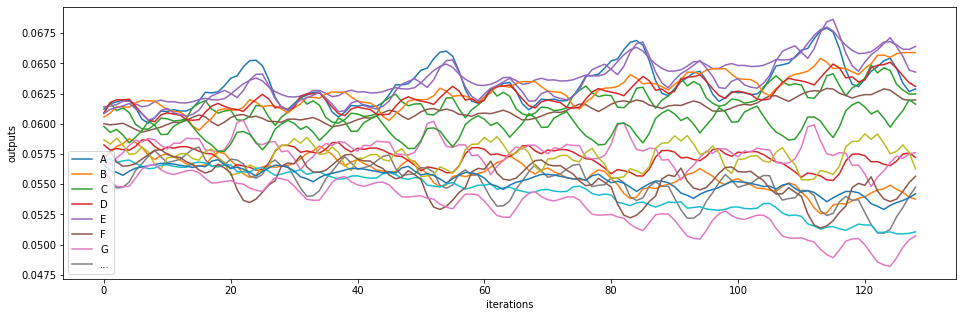

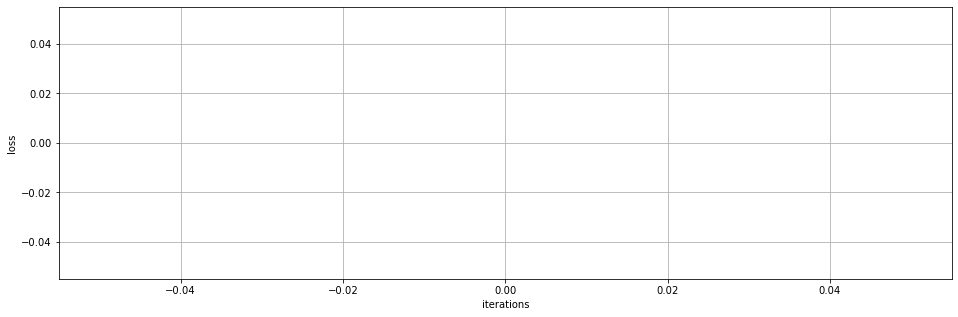

EEOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOOOOLLLLLLLLLLOOOOOOOOOOOO
---------------
epoch 1
---------------
epoch 2
---------------
epoch 3
---------------
epoch 4
---------------
epoch 5
---------------
epoch 6
---------------
epoch 7
---------------
epoch 8
---------------
epoch 9
---------------
epoch 10
---------------
epoch 10
learning rate: 0.0005
sample 0
output: 
[[0.07006413]
 [0.05314995]
 [0.07168023]
 [0.05668823]
 [0.06749976]
 [0.06790951]
 [0.04174941]
 [0.0444574 ]
 [0.08252434]
 [0.04116998]
 [0.05608112]
 [0.06931495]
 [0.0486376 ]
 [0.06129315]
 [0.0763071 ]
 [0.05112062]
 [0.04035252]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 10
learning rate: 0.0005
sample 101
o

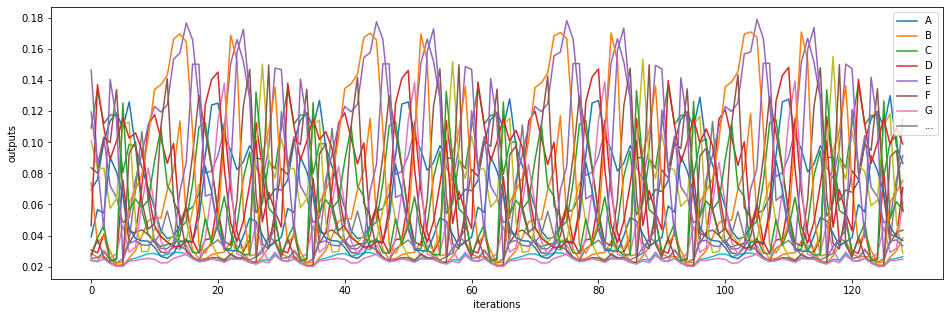

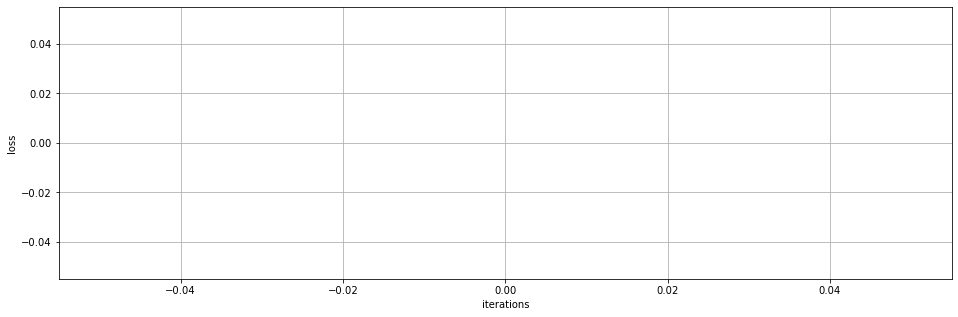

DLLEOFMINEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMINEOFMPLEOFMINEOOFMPEEOFMPLEOFMIN
---------------
epoch 11
---------------
epoch 12
---------------
epoch 13
---------------
epoch 14
---------------
epoch 15
---------------
epoch 16
---------------
epoch 17
---------------
epoch 18
---------------
epoch 19
---------------
epoch 20
---------------
epoch 20
learning rate: 0.0005
sample 0
output: 
[[0.06825674]
 [0.0480224 ]
 [0.07866133]
 [0.04389337]
 [0.06003391]
 [0.07213033]
 [0.03640034]
 [0.0439777 ]
 [0.13576362]
 [0.03548171]
 [0.05073135]
 [0.07539499]
 [0.03387331]
 [0.04482896]
 [0.09320801]
 [0.04117251]
 [0.03816943]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 20
learning rate: 0.0005
sam

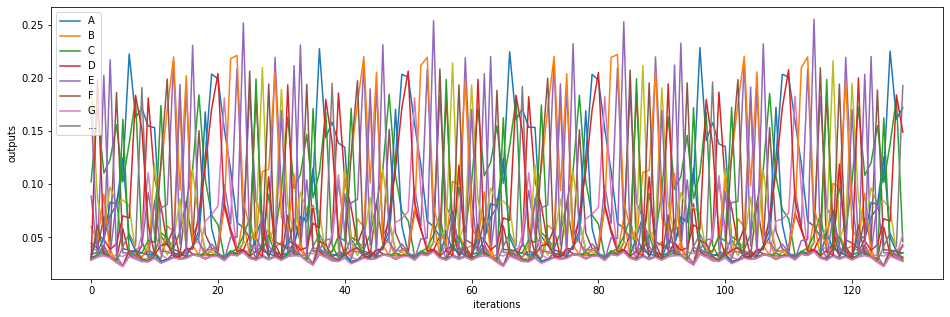

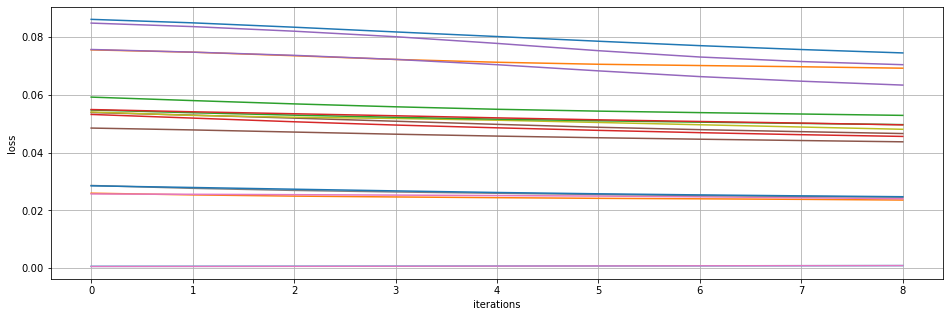

DAMPLILEOFMACHDAMPLINEOFMLEOFMLEOFMACHDLLICEOFMAELLOCKANGLLLEOFMACHDAMPLILEOFMACHDAMPLINEOFMLEOFMLEOFMACHDLLICEOFMAELLOCKANGLLLEOFMACHDAMPLILEOFMACHDAMPLINEOFMLEOFMLEOFMACHDLLICEOFMAELLOCKANGLLLEOFMACHDAMPLILEOFMACHDAMPLINEOFMLEOFMLEOFMACHDLLICEOFMAELLOCKANGLLLEOFMACHDAMPLILEOFMACHDAMPLINEOFMLEOFMLE
---------------
epoch 21
---------------
epoch 22
---------------
epoch 23
---------------
epoch 24
---------------
epoch 25
---------------
epoch 26
---------------
epoch 27
---------------
epoch 28
---------------
epoch 29
---------------
epoch 30
---------------
epoch 30
learning rate: 0.0005
sample 0
output: 
[[0.06904094]
 [0.03677612]
 [0.07512865]
 [0.04117069]
 [0.05460979]
 [0.0753661 ]
 [0.03616356]
 [0.04469644]
 [0.15790397]
 [0.03354969]
 [0.04510336]
 [0.10283291]
 [0.03061322]
 [0.03518954]
 [0.08702791]
 [0.03712568]
 [0.03770143]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 30
learning rate: 0.0005
sam

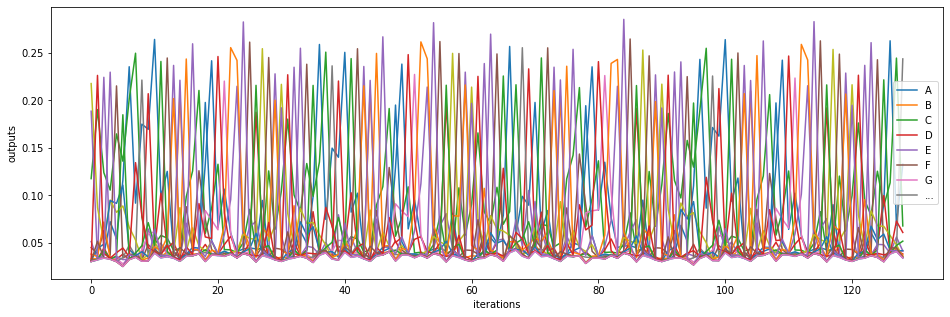

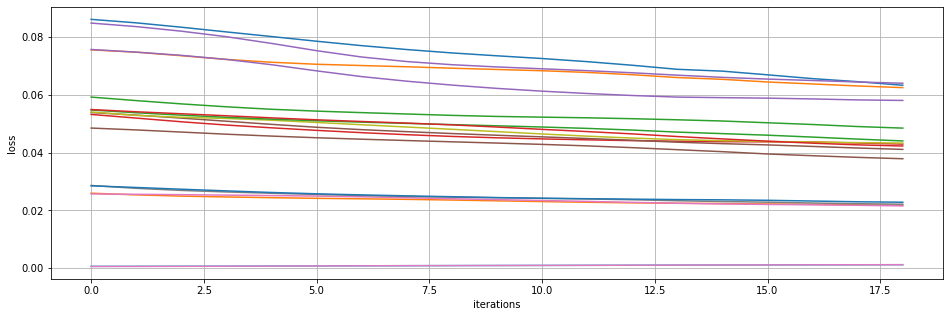

DAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAMPEOFMACHDAM
---------------
epoch 31
---------------
epoch 32
---------------
epoch 33
---------------
epoch 34
---------------
epoch 35
---------------
epoch 36
---------------
epoch 37
---------------
epoch 38
---------------
epoch 39
---------------
epoch 40
---------------
epoch 40
learning rate: 0.0005
sample 0
output: 
[[0.07093807]
 [0.03072879]
 [0.07158477]
 [0.04095873]
 [0.04594454]
 [0.09724613]
 [0.03709032]
 [0.043497  ]
 [0.16925689]
 [0.03239172]
 [0.03914137]
 [0.1110276 ]
 [0.02921852]
 [0.03212834]
 [0.07616833]
 [0.03753169]
 [0.03514721]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 40
learning rate: 0.0005
sam

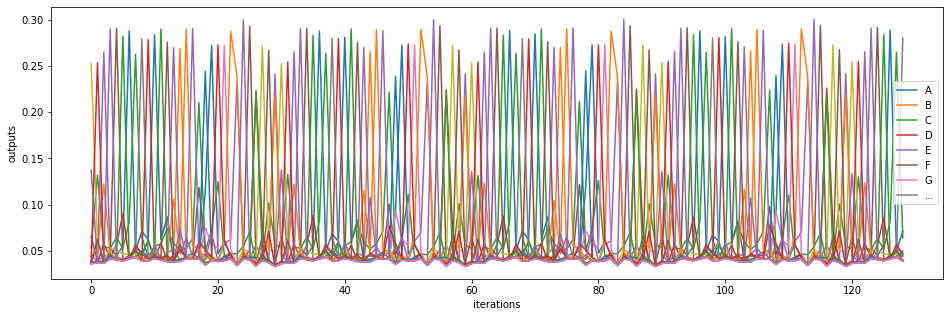

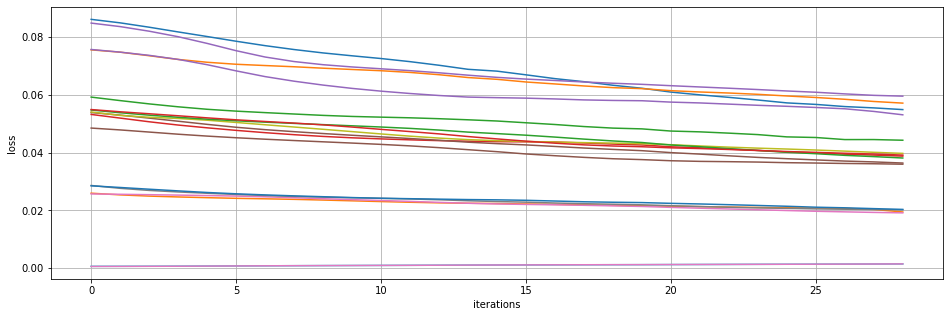

DAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKANGLLEOFMACHDAMPEBLOCKANGLLOICKAN
---------------
epoch 41
---------------
epoch 42
---------------
epoch 43
---------------
epoch 44
---------------
epoch 45
---------------
epoch 46
---------------
epoch 47
---------------
epoch 48
---------------
epoch 49
---------------
epoch 50
---------------
epoch 50
learning rate: 0.0005
sample 0
output: 
[[0.06682799]
 [0.02703525]
 [0.06676146]
 [0.04686529]
 [0.03714942]
 [0.1206904 ]
 [0.03762724]
 [0.04227401]
 [0.18018597]
 [0.02999968]
 [0.03367298]
 [0.1125403 ]
 [0.02722367]
 [0.03038699]
 [0.07034681]
 [0.03882729]
 [0.03158526]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 50
learning rate: 0.0005
sam

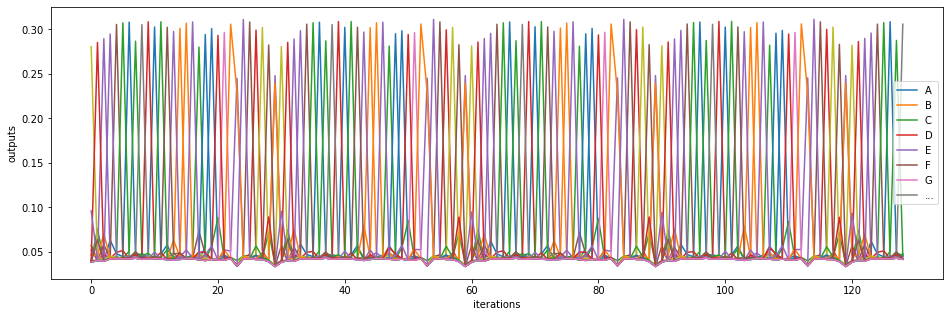

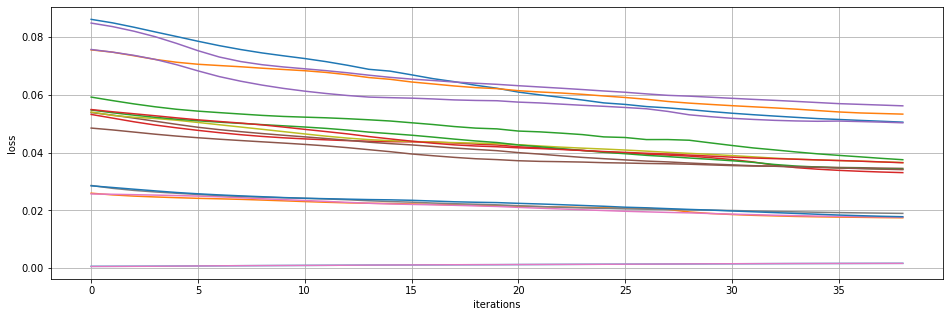

DAMPEBLOCKANGLEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFD
---------------
epoch 51
---------------
epoch 52
---------------
epoch 53
---------------
epoch 54
---------------
epoch 55
---------------
epoch 56
---------------
epoch 57
---------------
epoch 58
---------------
epoch 59
---------------
epoch 60
---------------
epoch 60
learning rate: 0.0005
sample 0
output: 
[[0.06531705]
 [0.02585172]
 [0.06697063]
 [0.04941645]
 [0.0349609 ]
 [0.13722442]
 [0.03873794]
 [0.043082  ]
 [0.17956854]
 [0.02902653]
 [0.0325004 ]
 [0.09783049]
 [0.0264172 ]
 [0.03059439]
 [0.0734951 ]
 [0.03887745]
 [0.03012879]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 60
learning rate: 0.0005
sam

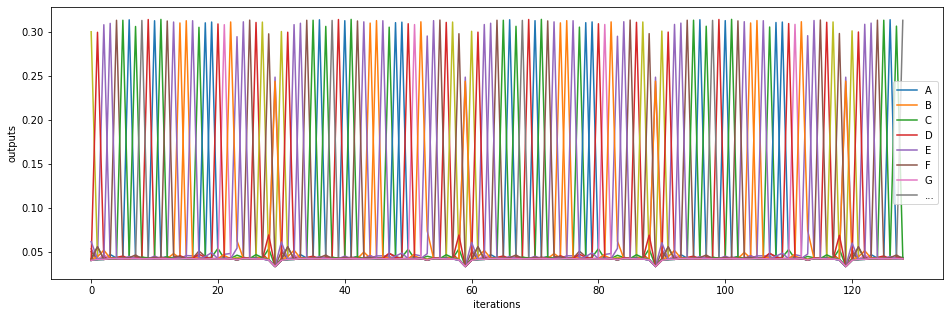

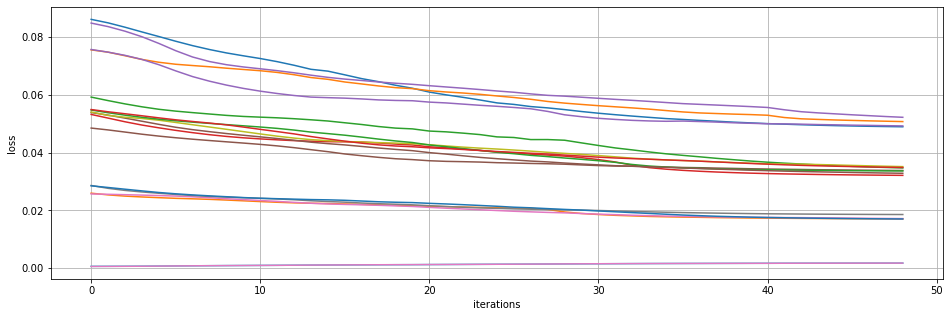

DAMPEBLOCKANGLEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFDIPEOFD
---------------
epoch 61
---------------
epoch 62
---------------
epoch 63
---------------
epoch 64
---------------
epoch 65
---------------
epoch 66
---------------
epoch 67
---------------
epoch 68
---------------
epoch 69
---------------
epoch 70
---------------
epoch 70
learning rate: 0.0005
sample 0
output: 
[[0.06530186]
 [0.02543678]
 [0.06420479]
 [0.05436417]
 [0.03387829]
 [0.14741525]
 [0.03787959]
 [0.04369966]
 [0.18065653]
 [0.02879069]
 [0.03138311]
 [0.08867273]
 [0.0262083 ]
 [0.03121263]
 [0.07243219]
 [0.03878781]
 [0.02967563]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 70
learning rate: 0.0005
sam

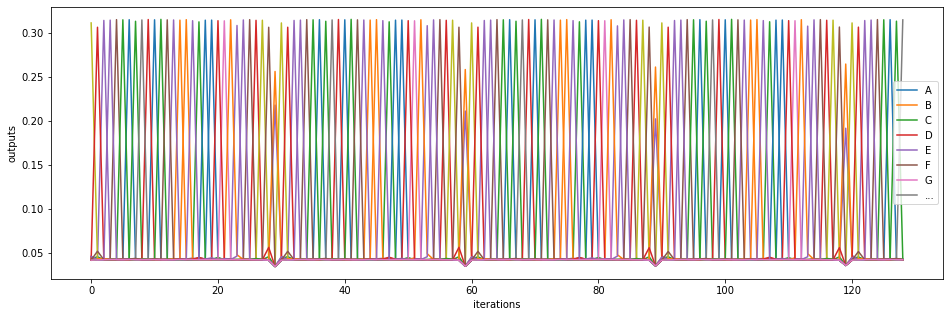

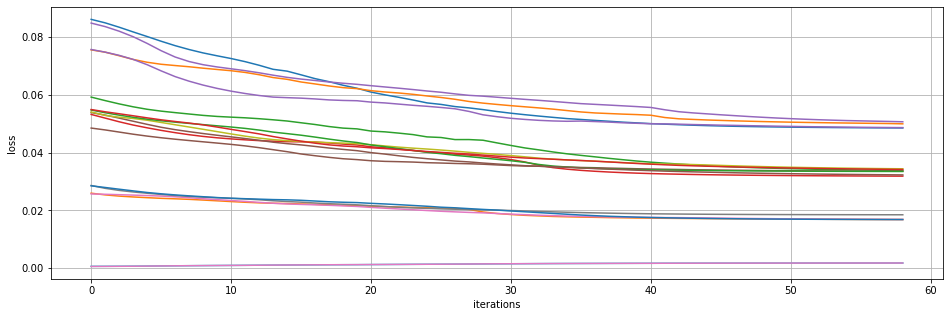

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 71
---------------
epoch 72
---------------
epoch 73
---------------
epoch 74
---------------
epoch 75
---------------
epoch 76
---------------
epoch 77
---------------
epoch 78
---------------
epoch 79
---------------
epoch 80
---------------
epoch 80
learning rate: 0.0005
sample 0
output: 
[[0.06609582]
 [0.02543303]
 [0.04725346]
 [0.06158505]
 [0.03050364]
 [0.15541613]
 [0.03711094]
 [0.04475844]
 [0.18363333]
 [0.02901557]
 [0.03112163]
 [0.08033097]
 [0.02646463]
 [0.03224502]
 [0.07868081]
 [0.04065982]
 [0.02969172]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 80
learning rate: 0.0005
sam

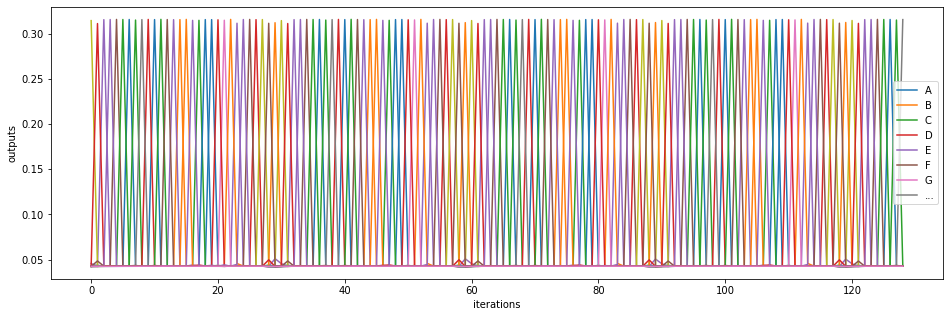

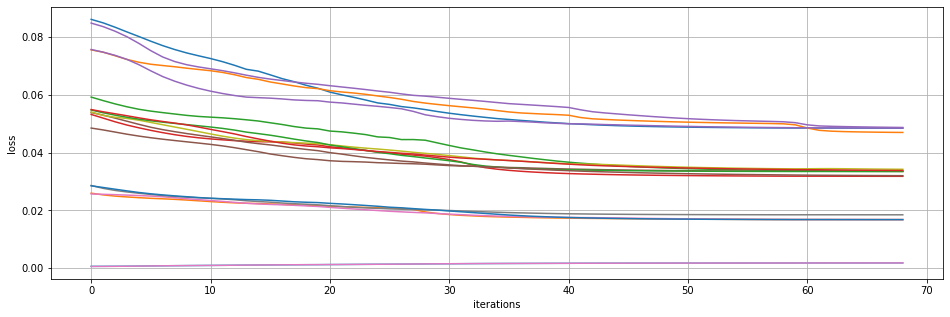

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 81
---------------
epoch 82
---------------
epoch 83
---------------
epoch 84
---------------
epoch 85
---------------
epoch 86
---------------
epoch 87
---------------
epoch 88
---------------
epoch 89
---------------
epoch 90
---------------
epoch 90
learning rate: 0.0005
sample 0
output: 
[[0.06730104]
 [0.02577962]
 [0.04534796]
 [0.0624197 ]
 [0.03088809]
 [0.16172331]
 [0.03293036]
 [0.04565723]
 [0.18810333]
 [0.0293482 ]
 [0.03059548]
 [0.06646874]
 [0.02691394]
 [0.03320065]
 [0.082145  ]
 [0.04113766]
 [0.03003971]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 90
learning rate: 0.0005
sam

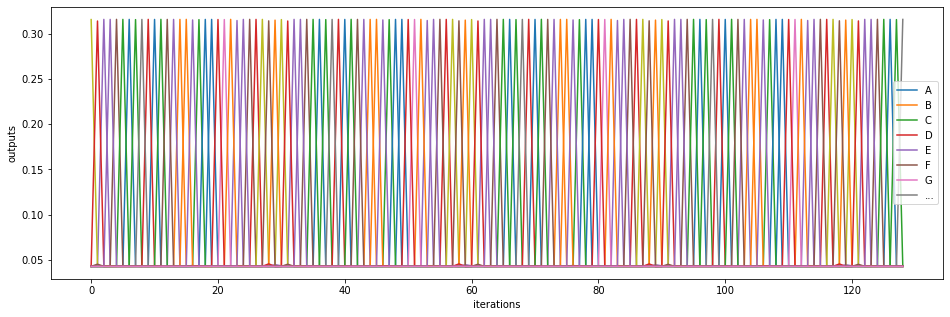

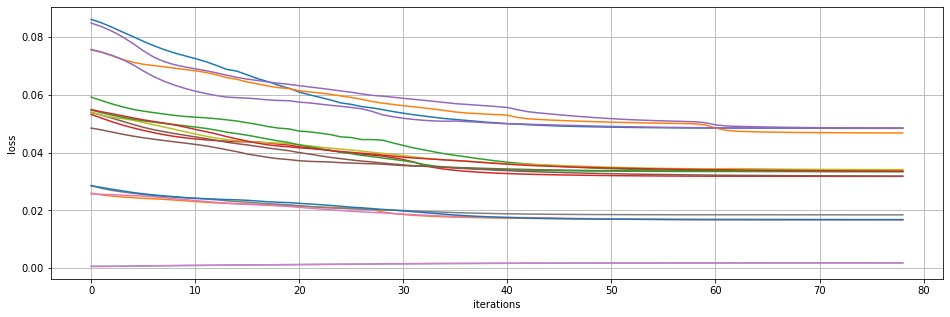

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 91
---------------
epoch 92
---------------
epoch 93
---------------
epoch 94
---------------
epoch 95
---------------
epoch 96
---------------
epoch 97
---------------
epoch 98
---------------
epoch 99
---------------
epoch 100
---------------
epoch 100
learning rate: 0.0005
sample 0
output: 
[[0.06777802]
 [0.02600966]
 [0.05270308]
 [0.06344652]
 [0.031905  ]
 [0.16253486]
 [0.03008345]
 [0.0457415 ]
 [0.19093081]
 [0.02938688]
 [0.03020052]
 [0.05508193]
 [0.02717946]
 [0.03147467]
 [0.08463443]
 [0.04080133]
 [0.03010787]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 100
learning rate: 0.0005


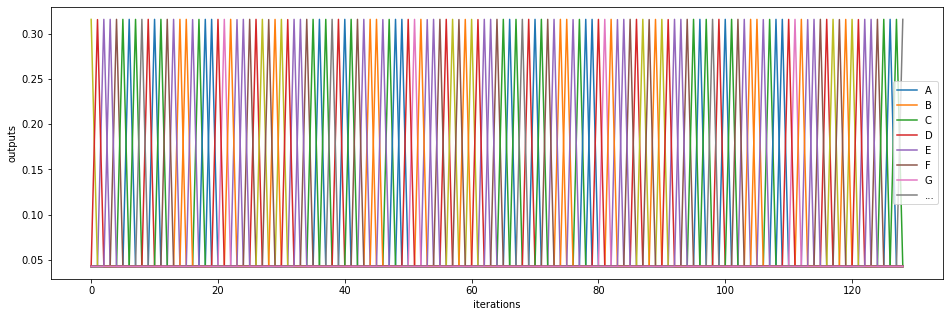

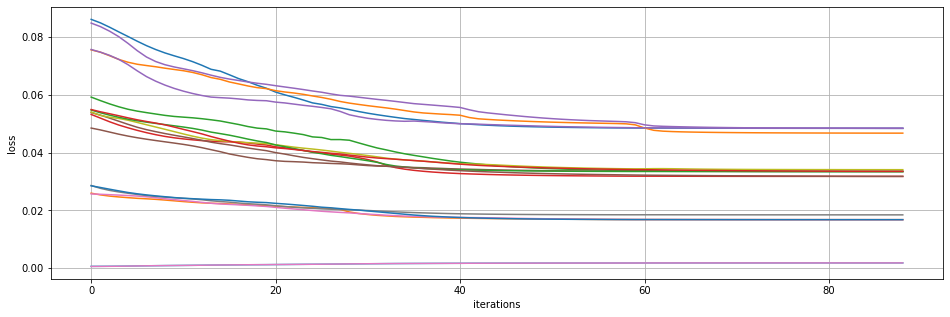

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 101
---------------
epoch 102
---------------
epoch 103
---------------
epoch 104
---------------
epoch 105
---------------
epoch 106
---------------
epoch 107
---------------
epoch 108
---------------
epoch 109
---------------
epoch 110
---------------
epoch 110
learning rate: 0.0005
sample 0
output: 
[[0.06782122]
 [0.02624524]
 [0.06023787]
 [0.06685855]
 [0.03366886]
 [0.15329723]
 [0.02865703]
 [0.04517078]
 [0.19317426]
 [0.02937225]
 [0.030052  ]
 [0.05011973]
 [0.02741697]
 [0.02930269]
 [0.08882995]
 [0.03972875]
 [0.03004664]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 110
learning rate

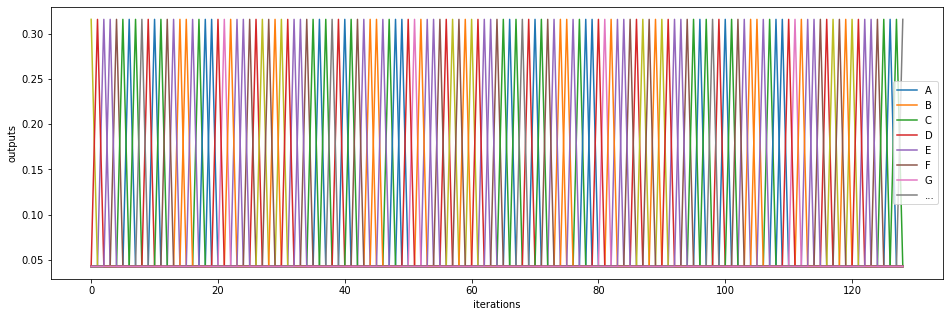

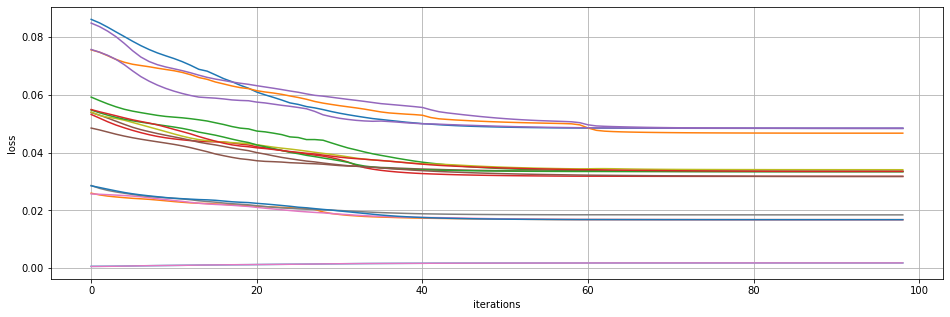

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 111
---------------
epoch 112
---------------
epoch 113
---------------
epoch 114
---------------
epoch 115
---------------
epoch 116
---------------
epoch 117
---------------
epoch 118
---------------
epoch 119
---------------
epoch 120
---------------
epoch 120
learning rate: 0.0005
sample 0
output: 
[[0.06823996]
 [0.02640564]
 [0.05608339]
 [0.07614743]
 [0.03416455]
 [0.15109683]
 [0.02841166]
 [0.04521782]
 [0.19457096]
 [0.02943371]
 [0.02998947]
 [0.04380663]
 [0.02761369]
 [0.02832709]
 [0.09010268]
 [0.04028438]
 [0.03010412]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 120
learning rate

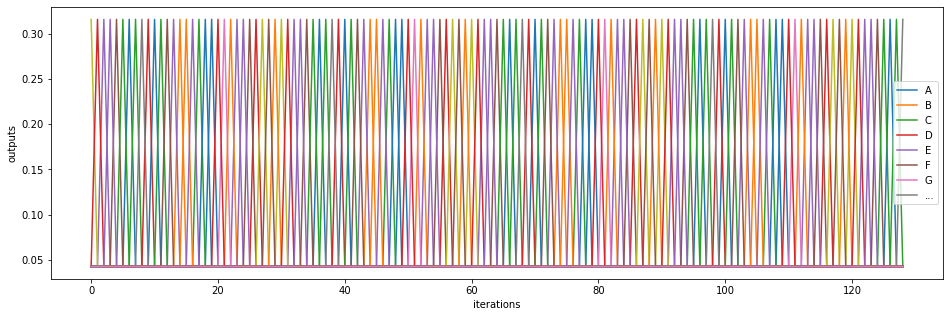

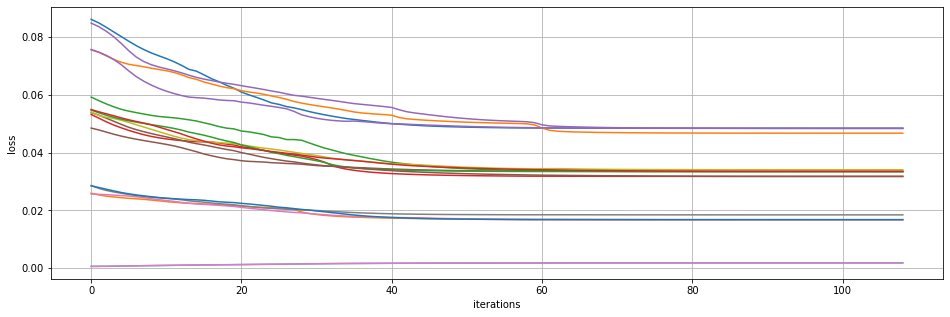

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 121
---------------
epoch 122
---------------
epoch 123
---------------
epoch 124
---------------
epoch 125
---------------
epoch 126
---------------
epoch 127
---------------
epoch 128
---------------
epoch 129
---------------
epoch 130
---------------
epoch 130
learning rate: 0.0005
sample 0
output: 
[[0.06853889]
 [0.02650216]
 [0.05036924]
 [0.08017235]
 [0.03382961]
 [0.15485484]
 [0.02830103]
 [0.04498598]
 [0.19539752]
 [0.02938421]
 [0.02982048]
 [0.03932831]
 [0.02775071]
 [0.02801148]
 [0.09202456]
 [0.04066689]
 [0.03006173]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
---------------
epoch 130
learning rate

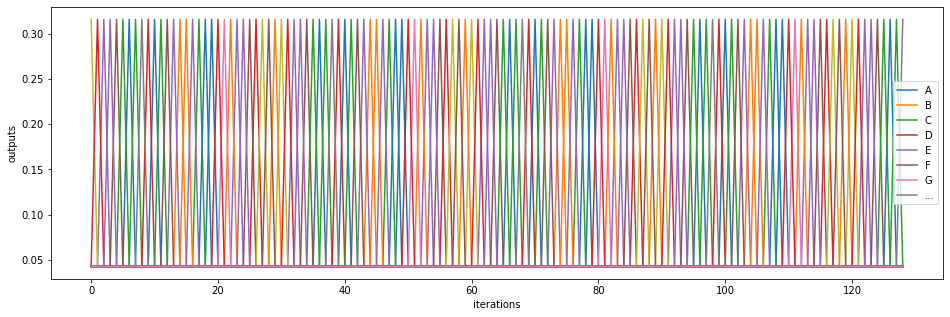

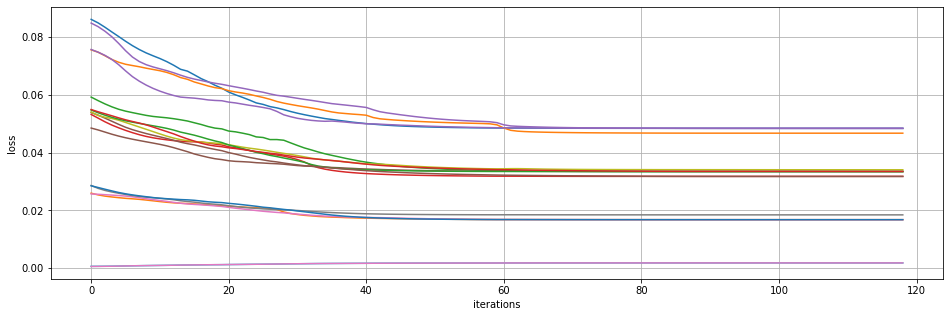

DAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACHDAMPEBLOCKANGLEOFDIPLINEOFMACH
---------------
epoch 131
---------------
epoch 132
---------------
epoch 133
---------------
epoch 134
---------------
epoch 135
---------------
epoch 136
---------------
epoch 137


In [ ]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.0000
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        if i > len(input_data)-1 - 130:
            outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 30, i+1)
  
        if e%10 == 0 and i%101 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%10 == 0:        
        print("-----------------")
        print("average loss: ")
        print(str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.legend(["A", "B", "C", "D", "E", "F", "G", "..."])
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    if e > 10:
        losses.append(loss/len(input_data))
    if e > 180:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-3].inputs))

In [ ]:
print(str(network.layers[-1].bz))

In [ ]:
print(str(network.layers[-1].br))

In [ ]:
print(str(network.layers[-1].Wz))

In [ ]:
print(str(network.layers[-1].Wr))

In [ ]:
print(str(network.layers[-1].Wh))

In [ ]:
print(str(network.layers[-1].Ur))

In [ ]:
print(str(network.layers[-1].Uz))

In [ ]:
print(str(network.layers[-1].Uh))

In [ ]:
print(str(network.layers[-1].bh))